### Task 1: Dataset 2

In [119]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
%matplotlib inline

In [120]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [121]:
theta = torch.tensor([1., 1.], requires_grad=True, dtype=torch.float64)

In [122]:
x_tensor = torch.tensor(x1, dtype=torch.float64).reshape(-1, 1)
X = torch.cat((torch.ones(x_tensor.shape), x_tensor), 1)
y = torch.tensor(y, dtype=torch.float64).reshape(-1, 1)

def true_gradient():
    y_pred = (X @ theta).reshape(-1, 1)
    loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
    loss.backward()
    true_grad = theta.grad.clone()
    true_loss = loss.data.clone()
    return true_grad, true_loss

true_grad, true_loss = true_gradient()
display(true_grad, true_loss, theta)

tensor([-5.6164, -0.5630], dtype=torch.float64)

tensor(9.3556, dtype=torch.float64)

tensor([1., 1.], dtype=torch.float64, requires_grad=True)

In [123]:
opt_theta = None

def compute_loss_analytical(X=X, y=y, theta_opt=None):
    x_tensor = X.clone().detach()
    y_tensor = y.clone().detach()
    if theta_opt is None:
        theta_opt = torch.inverse(x_tensor.T @ x_tensor) @ x_tensor.T @ y_tensor
	
    y_pred_tensor = (x_tensor @ theta_opt).reshape(-1, 1)
    loss_opt = torch.mean((y_pred_tensor - y_tensor) ** 2, dtype=torch.float64)
    return loss_opt.item()

loss_opt = compute_loss_analytical()
display(loss_opt)

0.5957541565733318

In [124]:

x_tensor = X.clone().detach()
y_tensor = y.clone().detach()
opt_theta = torch.inverse(x_tensor.T @ x_tensor) @ x_tensor.T @ y_tensor

In [125]:
all = {'bgd': 'Batch Gradient Descent', 'sgd': 'Stochastic Gradient Descent'}

def gradient_descent(grad_type: str='bgd', epochs=5000, eps=1e-3, alpha=1e-2, momentum=None):
    loss_vals = []
    
    grad_vals = []
    momentum_vals = []
    start_theta = torch.tensor([[0.0], [0.0]], dtype=torch.float64, requires_grad=True)
    theta_copy = start_theta.clone().detach().requires_grad_(True)
    theta_vals = [theta_copy.clone()]
    theta_copy.requires_grad = True
    epoch = 1
    latest_loss = 0
    change = torch.zeros(theta_copy.shape)
    iterations = 0
    while epoch <= epochs:
        epoch_loss = None
        if grad_type == 'bgd':
            y_pred = (X @ theta_copy).reshape(-1, 1)
            loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
            loss.backward()

            with torch.no_grad():
                if momentum is not None:
                    new_change = alpha * theta_copy.grad + momentum * change
                    theta_copy -= new_change
                    change = new_change
                else:
                    theta_copy -= alpha * theta_copy.grad

            grad_vals.append(theta_copy.grad)
            theta_copy.grad.zero_()

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2, dtype=torch.float64).item()
            epoch_loss = latest_loss
            iterations += 1
    

        else:
            random_permutation = torch.randperm(num_samples)
            X_shuffled = X[random_permutation].clone().detach()
            y_shuffled = y[random_permutation].clone().detach()
            stochastic_losses = []
            last_grad = None

            for i in range(num_samples):
                X_i = X_shuffled[i].clone().detach()
                y_i = y_shuffled[i].clone().detach()
                y_pred = (X_i @ theta_copy)

                loss = torch.mean((y_pred - y_i) ** 2, dtype=torch.float64)
                loss.backward()
                stochastic_losses.append(loss.item())

                with torch.no_grad():
                    if momentum is not None:
                        new_change = alpha * theta_copy.grad + momentum * change
                        theta_copy -= new_change
                        change = new_change
                    else:
                        theta_copy -= alpha * theta_copy.grad

                last_grad = theta_copy.grad
                theta_copy.grad.zero_()

            grad_vals.append(last_grad)
            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2).item()
            epoch_loss = np.mean(stochastic_losses)
            iterations += num_samples

        loss_vals.append(epoch_loss)
        theta_vals.append(theta_copy.clone())

        if change is None:
            momentum_vals.append(torch.zeros_like(theta_copy.grad))
        else:
            momentum_vals.append(change.clone())

        if torch.norm(theta_copy.squeeze() - opt_theta.squeeze()) <= eps:
            return loss_vals, theta_vals, grad_vals, momentum_vals, iterations, epoch

        epoch += 1
    return loss_vals, theta_vals, grad_vals, momentum_vals, iterations, epoch

In [126]:
def plot_loss_vs_epochs(momentum=None, epoch_cap=None):
    iters_per_class = {}
    
    for grad_type in ['bgd', 'sgd']:
        losses, thetas, grads, momentums, iters, epoch = gradient_descent(grad_type=grad_type, momentum=None)
        iters_per_class[all[grad_type]] = iters
        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)
        display(all[grad_type], np.min(losses))
        if epoch_cap is not None:
            plt.plot(epochs[:epoch_cap], losses[:epoch_cap], marker='.')
        else:
            plt.plot(epochs, losses, marker='.')
        plt.grid(visible=True)
        plt.title(f'Loss vs. Epochs for {all[grad_type]}')
        if epoch_cap is not None:
            plt.xlim(left=1)
        plt.hlines(loss_opt, 0, len(epochs), linestyles='--', colors='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

### Visualizing the Convergence Process for Vanilla Gradient Descent

'Batch Gradient Descent'

0.5957544613129417

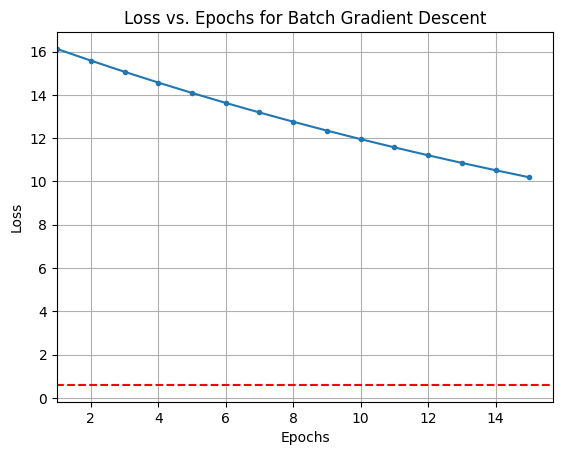

'Stochastic Gradient Descent'

0.603995845110849

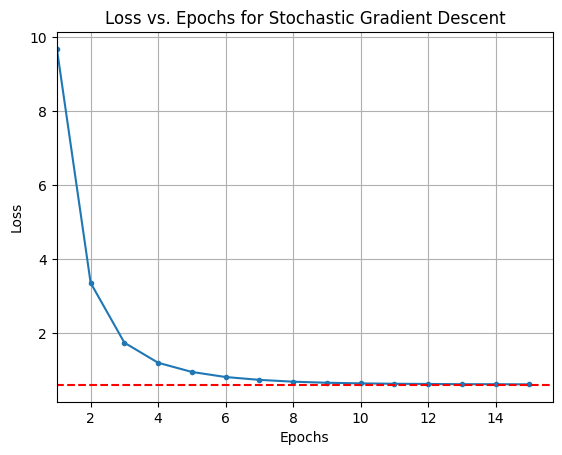

In [127]:
plot_loss_vs_epochs(momentum=None, epoch_cap=15)

'Batch Gradient Descent'

0.5957544613129417

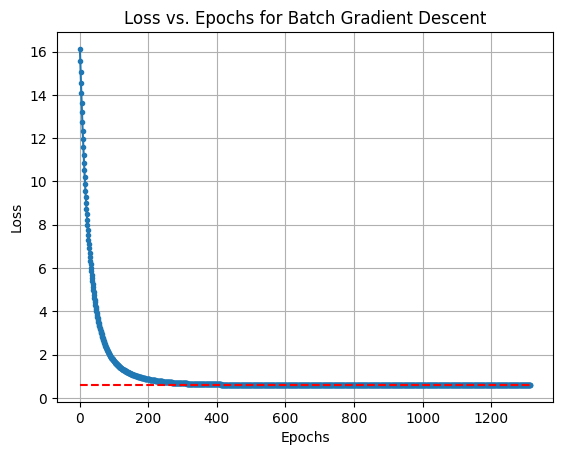

'Stochastic Gradient Descent'

0.6040237802953005

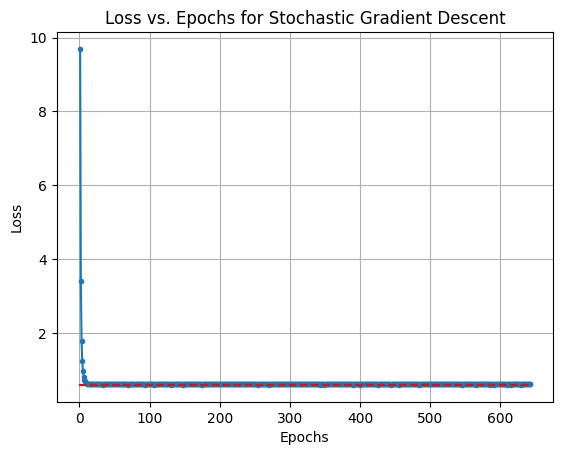

In [128]:
plot_loss_vs_epochs(momentum=None, epoch_cap=None)

### Visualizing the Convergence Process for Gradient Descent with momentum

'Batch Gradient Descent'

0.5957544613129417

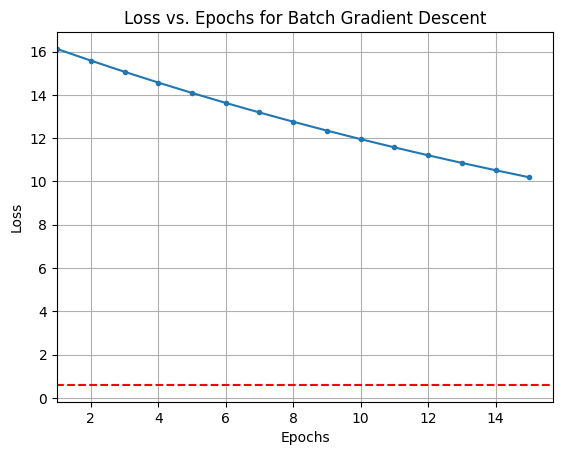

'Stochastic Gradient Descent'

0.6025264287733053

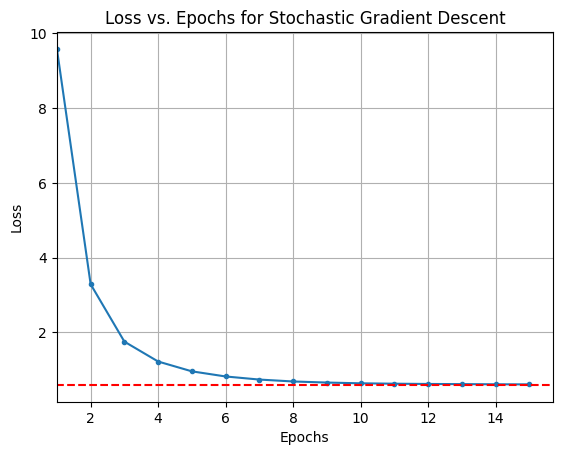

In [129]:
plot_loss_vs_epochs(momentum=0.9, epoch_cap=15)

'Batch Gradient Descent'

0.5957544613129417

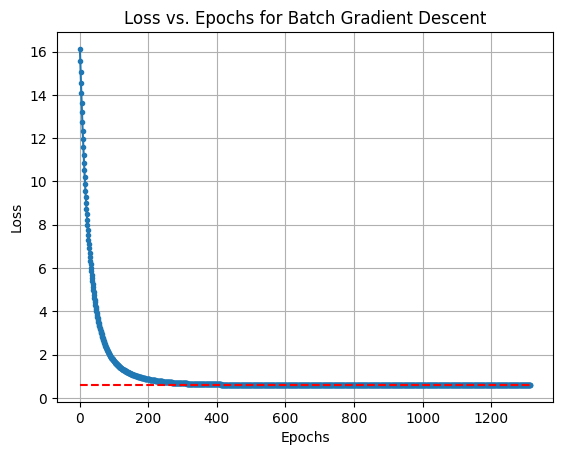

'Stochastic Gradient Descent'

0.6031369571181294

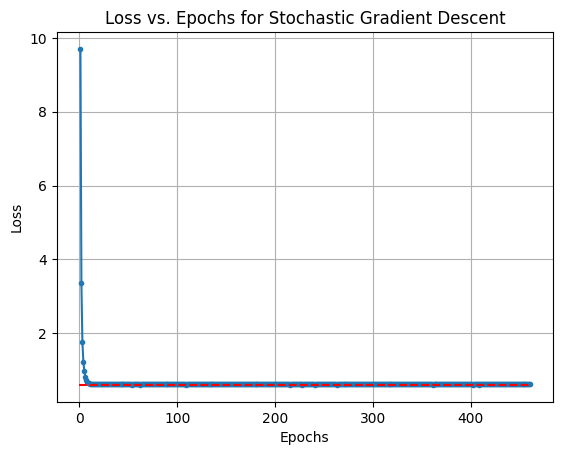

In [130]:
plot_loss_vs_epochs(momentum=0.9, epoch_cap=None)

In [131]:
theta0_vals = np.linspace(-8, 8, 100)
theta1_vals = np.linspace(-8, 8, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

loss_grid = np.zeros_like(theta0_grid)
for i in range(len(theta0_vals)):
    for j in range(len(theta1_vals)):
        theta_temp = torch.tensor([theta0_vals[i], theta1_vals[j]], dtype=torch.float64)
        loss_grid[j, i] = compute_loss_analytical(X, y, theta_temp)

def plot_contour_with_trajectory(theta_vals, gradients, velocities, step_num, frames_dir, save_frames=True):
    fig, ax = plt.subplots()
    
    contour = ax.contour(theta0_grid, theta1_grid, loss_grid, levels=np.logspace(-1, 2, 20), cmap='coolwarm')
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title('Loss Contour Plot with Gradient Descent Path')
    fig.colorbar(contour, ax=ax)

    theta_vals_np = np.array([theta.detach().numpy() for theta in theta_vals])
    ax.quiver(theta_vals_np[:-1, 0], theta_vals_np[:-1, 1],
              theta_vals_np[1:, 0] - theta_vals_np[:-1, 0],
              theta_vals_np[1:, 1] - theta_vals_np[:-1, 1],
              angles='xy', scale_units='xy', scale=1, width=0.005, color='r', label='Gradient Descent Path')

    current_theta = theta_vals_np[-1]

    if velocities:
        current_velocity = velocities[-1].detach().numpy()
        ax.quiver(current_theta[0], current_theta[1],
                current_velocity[0], current_velocity[1],
                angles='xy', scale_units='xy', scale=1, width=0.005, color='green', label='Momentum')

    ax.scatter(theta_vals_np[0, 0], theta_vals_np[0, 1], color='blue', marker='o', label='Start')
    
    ax.legend()  

    if save_frames:
        frame_path = os.path.join(frames_dir, f'frame_{step_num:05d}.png')
        plt.savefig(frame_path)
    
    plt.close(fig)

def create_gif_from_frames(output_gif, frames_dir, duration=3):
    frame_paths = [os.path.join(frames_dir, frame) for frame in sorted(os.listdir(frames_dir)) if frame.endswith('.png')]
    
    frames = [imageio.imread(frame) for frame in frame_paths]
    imageio.mimsave(output_gif, frames, duration=duration)
    print(f"GIF saved as {output_gif}")

def clear_frames_dir(frames_dir):
    for file in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)

for momentum in [None, 0.9]:
    momentum_label = 'momentum_0.9' if momentum is not None else 'no_momentum'
    for grad_type in ['bgd', 'sgd']:
        grad_label = grad_type.upper()
        
        frames_dir = f'frames_{grad_label}_{momentum_label}/'
        os.makedirs(frames_dir, exist_ok=True)
        
        loss_vals, theta_vals, grad_vals, momentum_vals, _, epoch = gradient_descent(grad_type=grad_type, momentum=momentum)
        for step_num, theta in enumerate(theta_vals):
            if step_num == 16:
                break
            plot_contour_with_trajectory(theta_vals[:step_num+1], grad_vals[:step_num+1], momentum_vals[:step_num+1], step_num, frames_dir)

        output_gif_path = f'gradient_descent_{grad_label}_{momentum_label}_15.gif'
        create_gif_from_frames(output_gif_path, frames_dir)

        clear_frames_dir(frames_dir)

GIF saved as gradient_descent_BGD_no_momentum_15.gif
GIF saved as gradient_descent_SGD_no_momentum_15.gif
GIF saved as gradient_descent_BGD_momentum_0.9_15.gif
GIF saved as gradient_descent_SGD_momentum_0.9_15.gif


### Average number of epochs and iterations for each method (vanilla) to converge

In [132]:
iters_per_class = {}
epochs_per_class = {}

for i in range(10):
    for grad_type in ['bgd', 'sgd']:
        losses, thetas, grads, momentum, iters, epoch = gradient_descent(grad_type=grad_type, momentum=None)
        if all[grad_type] not in iters_per_class:
            iters_per_class[all[grad_type]] = [iters]
        else:
            iters_per_class[all[grad_type]].append(iters)
        
        if all[grad_type] not in epochs_per_class:
            epochs_per_class[all[grad_type]] = [epoch]
        else:
            epochs_per_class[all[grad_type]].append(epoch)

        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)

for cls in iters_per_class:
    iters_per_class[cls] = np.mean(iters_per_class[cls])

for cls in epochs_per_class:
    epochs_per_class[cls] = np.mean(epochs_per_class[cls])

print(iters_per_class)
print(epochs_per_class)

{'Batch Gradient Descent': 1314.0, 'Stochastic Gradient Descent': 7168.0}
{'Batch Gradient Descent': 1314.0, 'Stochastic Gradient Descent': 179.2}


### Average number of epochs and iterations for each method with momentum

In [134]:
iters_per_class = {}
epochs_per_class = {}

for i in range(10):
    for grad_type in ['bgd', 'sgd']:
        losses, thetas, grads, momentum, iters, epoch = gradient_descent(grad_type=grad_type, momentum=0.9,epochs=1000)
        if all[grad_type] not in iters_per_class:
            iters_per_class[all[grad_type]] = [iters]
        else:
            iters_per_class[all[grad_type]].append(iters)
        
        if all[grad_type] not in epochs_per_class:
            epochs_per_class[all[grad_type]] = [epoch]
        else:
            epochs_per_class[all[grad_type]].append(epoch)

        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)

for cls in iters_per_class:
    iters_per_class[cls] = np.mean(iters_per_class[cls])

for cls in epochs_per_class:
    epochs_per_class[cls] = np.mean(epochs_per_class[cls])

print(iters_per_class)
print(epochs_per_class)

{'Batch Gradient Descent': 149.0, 'Stochastic Gradient Descent': 40000.0}
{'Batch Gradient Descent': 149.0, 'Stochastic Gradient Descent': 1001.0}


### Observations on Vanilla Gradient Descent

When computing the average number of steps required for each method to converge, it is observed that stochastic gradient descent (SGD) takes significantly more parameter update steps than full-batch gradient descent (BGD). Although SGD may complete fewer epochs before convergence, each epoch involves an update after every sample, resulting in a much higher total number of steps.

In the experiment:

Average steps (updates) for BGD ≈ 1314

Average steps (updates) for SGD ≈ 7168

Average epochs for BGD ≈ 1314

Average epochs for SGD ≈ 179.2

The higher step count in SGD arises because it performs one update per sample, whereas BGD performs a single update after processing the entire dataset. Consequently, SGD’s loss trajectory exhibits noticeable fluctuations due to the noise in individual gradient estimates, while BGD shows a smoother and more stable descent.

However, since each SGD update uses only one data point, it is computationally lighter per iteration and often achieves practical convergence faster despite its noisier path. In contrast, BGD’s updates are more computationally expensive per step but yield steadier convergence toward the minimum.

### Observations on Gradient Descent with Momentum
When momentum was introduced (momentum coefficient = 0.9, learning rate = 0.01):

BGD with momentum converged in approximately 149 steps, much faster than vanilla BGD (1314 steps).

SGD with momentum, however, required around 40,000 steps and failed to converge within the same threshold for most runs.

This opposite behavior occurs because:

In BGD, the momentum term helps accumulate gradient direction over full-batch updates, allowing the optimizer to move consistently toward the minimum while reducing oscillations. Since the gradients are computed over the entire dataset, the updates are stable, and momentum accelerates convergence efficiently — reducing the total steps drastically.

In SGD, each update is based on a single noisy sample. The momentum term, instead of smoothing, amplifies the noise because it accumulates random fluctuations in gradient direction. With the same relatively large learning rate (0.01), this causes overshooting and oscillations, preventing stable convergence and significantly increasing the total number of steps.

Thus, while momentum improves BGD, it destabilizes SGD under the same hyperparameters — highlighting that momentum requires careful tuning of the learning rate when used with stochastic updates.